In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [6]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [11]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
variables = open('./ModeloV2TodosMenosVariables.txt','r')
##ModeloV1T1

In [8]:
modelo

LGBMClassifier(colsample_bytree=0.84, force_col_wise='True',
               importance_type='gini', learning_rate=0.07, max_depth=20,
               min_child_weight=0.0026, n_estimators=520, num_leaves=30,
               objective='binary', scale_pos_weight=0.003, subsample=1)

# Veo si puedo sacar los nombres directo del modelo q cargue


var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'day_name_receiver_Friday', 'day_name_receiver_Monday', 
         'day_name_receiver_Saturday', 'day_name_receiver_Sunday', 'day_name_receiver_Thursday', 'day_name_receiver_Tuesday', 
         'day_name_receiver_Wednesday','id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X',
         '01_isMexico','tx_brancity', 'tx_brancity_total', 'ptx_brancity','idlocation_fraud']

var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365',
        'id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X']

var_input = [ 'branch_trans_3m', 'count_date_receiver_distinct','branch_has_fraud',
       'receiver_has_fraud',
       'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_4min',
       'location_nro_fraud', 'sender_trans_3m',
       'sender_nro_fraud', '01_isMexico',
       '01_sender_branch_state', '01_Var_range_hist', '01_receiver_fraud',
       '01_branch_fraud', '01_location_fraud', '01_sender_fraud',
       '01_isCashPick', '01_isBankDep',
       'sender_days_to_last_transaction_more365',
       'sender_days_to_last_transaction_more7m',
       '01_receiver_transaction_count', '01_sender_sending_days',
       '01_branch_working_days', '01_net_amount_receiver',
       '01_sender_minutes_since_last_transaction_2days',
       '01_sender_minutes_since_last_transaction_1day',
       '01_sender_days_to_last_transaction_365',
       '01_sender_days_to_last_transaction_7m', '01_hour_receiver',
       'day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6']

In [33]:
variables = open('./ModeloV2TodosMenosVariables.txt','r')
var_input = variables.read()

In [37]:
var_input = ['branch_trans_3m', 'count_date_receiver_distinct', 'branch_has_fraud', 'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_4min', 'location_nro_fraud', 'sender_trans_3m', 'sender_nro_fraud', '01_isMexico', '01_sender_branch_state', '01_Var_range_hist', '01_receiver_fraud', '01_branch_fraud', '01_location_fraud', '01_sender_fraud', '01_isCashPick', '01_isBankDep', 'sender_days_to_last_transaction_more7m', '01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', '01_sender_minutes_since_last_transaction_2days', '01_sender_days_to_last_transaction_365', '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [38]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

testeo =  pd.concat([X, Y], axis=1)

In [39]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]
dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [40]:
Y_target

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target
0,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False
2,True,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...
9754069,False,False,False,True,False,False,False,False
9754070,False,True,False,False,False,False,False,False
9754071,False,False,False,False,True,False,False,False
9754072,False,False,False,False,False,False,True,False


In [41]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [42]:
testeo['target'].value_counts(dropna=False)

target
False    9753910
True         164
Name: count, dtype: int64

In [43]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [44]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [45]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,9753905,5
1,157,7


<Axes: xlabel='score_rf', ylabel='Count'>

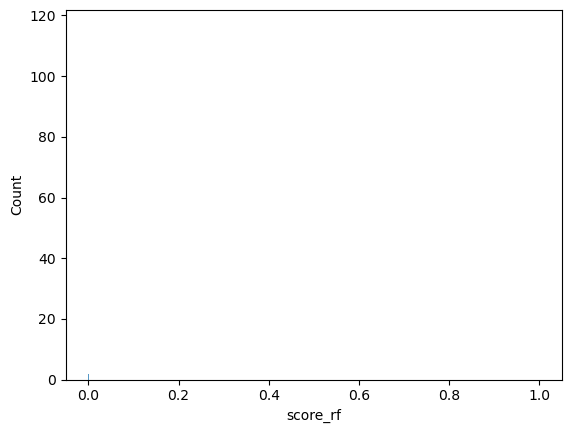

In [46]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [76]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
0.6585365853658537


In [77]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,9677,78
2,9732,22
3,9746,8
4,9747,7
5,9747,7
...,...,...
996,9754,0
997,9754,0
998,9753,0


In [78]:
#DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [84]:
#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             2.661479e-06  9.999999e-01
2             6.673608e-07  2.661349e-06
3             2.689684e-07  6.673038e-07
4             1.393344e-07  2.689663e-07
5             8.470027e-08  1.393284e-07
...                    ...           ...
996           4.481521e-14  5.050280e-14
997           3.866114e-14  4.481453e-14
998           3.224063e-14  3.866014e-14
999           2.497344e-14  3.223865e-14
1000          5.978928e-15  2.497344e-14

[1000 rows x 2 columns]

In [80]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,1348,1383,1363,1238,1430,1590,1403
2,1294,1259,1284,1253,1527,1671,1466
3,1342,1228,1259,1241,1523,1669,1492
4,1333,1245,1207,1166,1550,1732,1521
5,1332,1274,1158,1212,1520,1766,1492
6,1269,1311,1190,1177,1553,1793,1461
7,1285,1263,1224,1149,1499,1791,1543
8,1311,1227,1149,1149,1611,1764,1543
9,1271,1277,1238,1108,1613,1737,1510


In [81]:
#DECILES.to_csv ('./deciles.csv')

## One given week

In [85]:
tes[tes['target']==True].head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,receiver_date_first_transaction,receiver_date_last_transaction,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,count_date_receiver_distinct,sender_state,branch_has_fraud,fecha_last_fraud_branch,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_4min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_Var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
10732,A21933,8706,2023-09-12 17:35:54.623,MO0094,T057,10677071,700.0000,1,2023-09-12 17:35:54.623000000,2023-09-12 17:35:54.623000000,MEX,MEX35,MO,655,0,0,USA,Real,0,15,1460,91,FL,2,2023-09-12 17:20:45.447,0,4,1,0,0,1,700.0,0,9,17,True,False,1.00,False,True,False,False,False,True,0.0,0,0.0,0,0.0,0.0,0.0,0.000000,0.668024,0.714286,0.0,0.0,0.000000,0.000000,0.708333,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
24323,A23929,1911,2023-09-23 21:45:51.170,NC1584,T057,10303471,900.0000,1,2023-09-23 21:45:51.170000000,2023-09-23 21:45:51.170000000,MEX,MEX7,NC,222,87,17,USA,Real,125598,5,820,90,TX,10,2023-09-23 21:40:55.300,0,8,2,0,0,2,1200.0,0,9,21,True,False,0.75,False,True,False,False,False,True,17.0,0,17.0,0,0.0,0.0,0.0,0.988636,0.227088,0.918367,0.0,0.0,0.046575,0.080952,0.875000,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
40855,A23929,1909,2023-09-23 21:34:29.010,NC1584,T239,10731976,900.0000,1,2023-09-23 21:34:29.010000000,2023-09-23 21:34:29.010000000,MEX,MEX8,NC,222,0,0,USA,Real,0,6,818,90,TN,8,2023-09-23 21:22:25.430,0,6,3,0,0,1,900.0,0,9,21,True,False,1.00,False,True,False,False,False,True,0.0,0,0.0,0,0.0,0.0,0.0,0.000000,0.227088,0.918367,0.0,0.0,0.000000,0.000000,0.875000,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
51370,A21933,8703,2023-09-12 16:58:22.553,MO0094,T239,10676829,985.0000,1,2023-09-12 16:58:22.553000000,2023-09-12 16:58:22.553000000,MEX,MEX33,MO,655,0,0,USA,Real,0,18,1457,91,TX,0,NaT,0,2,1,0,0,1,985.0,0,9,16,True,False,1.00,False,False,False,False,False,True,0.0,0,0.0,0,0.0,0.0,0.0,0.000000,0.668024,1.000000,0.0,0.0,0.000000,0.000000,0.666667,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
69565,A09442,93555,2023-09-25 20:49:28.657,VA0593,T057,10742969,1900.0000,1,2023-09-25 20:49:28.657000000,2023-09-25 20:49:28.657000000,MEX,MEX11,VA,3783,0,9,USA,Distraction,None,None,2413,91,WA,0,NaT,0,2,1,0,0,1,0.0,0,9,20,True,False,inf,False,False,False,False,False,True,9.0,0,9.0,0,NaN,NaN,0.0,0.000000,1.000000,1.000000,NaN,NaN,0.024658,0.042857,0.833333,True,False,False,False,False,False,False,False,True,Fals

In [137]:
week_testigo = tes['date_receiver'].between('2023-09-22','2023-09-29')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(555947, (555947, 80), (555947, 11))

In [138]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

target,False,True
date_receiver,,
22,95282,0
23,114724,16
24,106442,0
25,77024,9
26,59827,0
27,53250,5
28,49368,0


In [139]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [140]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
date_receiver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22,70,70,69,75,72,72,74,65,67,72,67,72,75,60,87,71,73,83,63,84,95,78,80,89,80,86,85,77,87,73,81,77,70,79,89,91,79,65,86,61,75,86,63,73,74,68,75,95,81,74,81,91,111,82,71,75,77,91,79,64,95,90,84,86,69,77,79,86,72,73,64,75,83,91,78,87,92,86,72,90,82,77,93,87,59,78,81,74,79,84,83,98,83,87,81,83,74,87,87,96,89,65,85,95,77,86,91,71,100,85,76,91,89,102,90,72,98,94,86,82,73,96,87,82,68,76,79,99,99,71,72,75,96,80,111,90,94,90,76,73,89,82,68,84,95,99,104,79,74,93,78,95,76,88,89,78,78,92,98,68,88,93,85,77,96,106,92,83,98,88,92,99,92,66,96,97,80,87,72,77,87,83,101,84,86,107,100,96,111,78,95,99,81,90,87,92,81,81,72,89,89,109,91,78,74,88,104,94,97,102,86,69,91,85,100,121,91,87,90,95,93,101,87,83,99,102,83,109,71,88,89,85,95,80,96,110,92,80,94,103,108,101,86,93,88,77,94,93,96,93,...,105,111,94,104,89,101,129,116,112,94,109,111,90,96,90,107,97,98,114,114,110,105,103,96,101,91,96,120,106,95,103,129,120,81,136,121,112,100,116,100,110,116,115,99,113,115,93,100,82,105,104,123,117,96,108,119,99,120,106,116,104,119,101,105,87,101,112,115,90,112,98,96,106,123,110,90,89,96,100,115,103,116,109,103,112,109,121,86,109,83,105,132,109,81,106,118,101,101,113,103,97,96,101,123,119,121,96,105,126,110,116,117,108,127,98,110,118,99,122,101,98,110,91,105,104,117,112,108,109,103,106,113,114,81,125,98,120,106,115,105,95,118,113,118,113,106,116,117,125,109,116,112,113,108,101,107,118,104,85,115,100,96,97,121,112,106,122,106,108,123,115,111,104,110,121,114,115,113,107,122,86,94,116,105,117,108,110,103,104,106,107,100,116,136,94,122,96,123,103,112,106,102,106,109,101,119,121,102,104,94,10

In [141]:

pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

FRAUD_DECILE,1,2,3,5,6,7,28,464
date_receiver,,,,,,,,
23,12,0,2,1,1,0,0,0
25,6,2,0,0,0,0,0,1
27,3,0,0,0,0,1,1,0


In [143]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]

,date_receiver,fraud_classification,FRAUD_DECILE
24323,23,Real,3
40855,23,Real,1
69565,25,Distraction,1
70268,25,Real,2
119447,27,Real,7
174229,23,Real,5
250326,23,Real,6
322073,23,Distraction,3
331265,25,Distraction,1
443824,23,Real,1
